In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuweizhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('./data/cvpr_16-21.csv')
data.info()
abstract = list(data.Abstract)
title = list(data.TITLE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6869 entries, 0 to 6868
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    6869 non-null   int64  
 1   YEAR          6869 non-null   int64  
 2   TITLE         6869 non-null   object 
 3   Authors       6869 non-null   object 
 4   Abstract      6869 non-null   object 
 5   Affiliations  6865 non-null   object 
 6   Citations     5018 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 375.8+ KB


In [3]:
data.head(4)

,Unnamed: 0,YEAR,TITLE,Authors,Abstract,Affiliations,Citations
0,0,2016,Estimating Sparse Signals with Smooth Support ...,S. Shah; T. Goldstein; C. Studer,Conventional algorithms for sparse signal reco...,"['Univ. of Maryland, College Park, MD, USA', '...",NaN
1,1,2016,Parametric Object Motion from Blur,J. Gast; A. Sellent; S. Roth,Motion blur can adversely affect a number of v...,"['NA', 'NA', 'NA']",8.0
2,2,2016,Unsupervised Learning of Discriminative Attrib...,C. Huang; C. C. Loy; X. Tang,Attributes offer useful mid-level features to ...,"['Dept. of Inf. Eng., Chinese Univ. of Hong Ko...",30.0
3,4,2016,Symmetry reCAPTCHA,C. Funk; Y. Liu,This paper is a reaction to the poor performan...,"['Sch. of Electr. Eng. & Comput. Sci., Pennsyl...",12.0


In [4]:
samples = data.sample(4)
for _, s in samples.iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR})")
    print(f"Abstract: {s.Abstract}\n")

STCT: Sequentially Training Convolutional Networks for Visual Tracking (CVPR2016)
Abstract: Due to the limited amount of training samples, finetuning pre-trained deep models online is prone to overfitting. In this paper, we propose a sequential training method for convolutional neural networks (CNNs) to effectively transfer pre-trained deep features for online applications. We regard a CNN as an ensemble with each channel of the output feature map as an individual base learner. Each base learner is trained using different loss criterions to reduce correlation and avoid over-training. To achieve the best ensemble online, all the base learners are sequentially sampled into the ensemble via important sampling. To further improve the robustness of each base learner, we propose to train the convolutional layers with random binary masks, which serves as a regularization to enforce each base learner to focus on different input features. The proposed online training method is applied to visual

In [5]:
sw = nltk.corpus.stopwords.words('english')
sw.extend(['from', 'subject', 'using', 'via', 'new', 'work', 'different', 'introduce', 'existing', 'github', 'available', 'also', 'use', 'used', 'without', "propose", "improve",\
    "novel", "better", "extensive", "well", "eg", "however", "method", "proposed", \
    "'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'n', 'p', 'r', 'u', 'v', 'w', 'x'])

In [6]:
import string
puncs = dict.fromkeys(string.punctuation)
del puncs["-"]
table = str.maketrans(puncs)
# pre-process
lemm = nltk.WordNetLemmatizer()
abstract_proc = []
for i in range(len(abstract)):
    ab = abstract[i].strip().lower().translate(table).split()
    abstract_proc.append([lemm.lemmatize(w) for w in ab])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tf_vectorizer = CountVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tf = tf_vectorizer.fit_transform(abstract_proc)

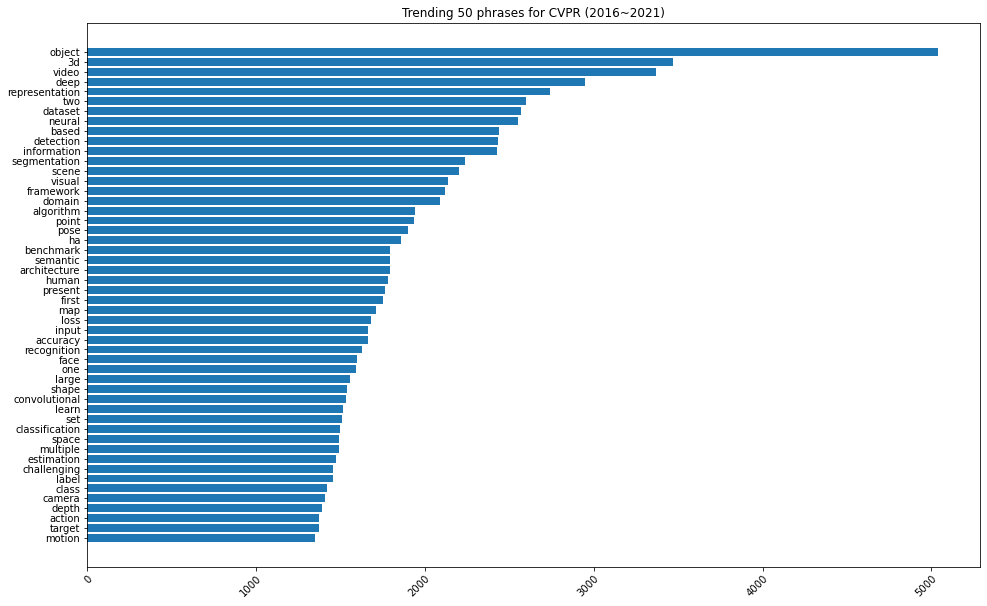

In [7]:
feature_count = pd.DataFrame({
    "feat_name": tf_vectorizer.get_feature_names_out(),
    "feat_count": tf.toarray().sum(axis=0).tolist()
})

vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(50)

fig, ax = plt.subplots(figsize=(16, 10))

ax.barh(y=np.flip(vals_to_display.feat_name.values), width=np.flip(vals_to_display.feat_count.values))
ax.set_title("Trending 50 phrases for CVPR (2016~2021)")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()

In [8]:
diversity_papers = data.loc[:, ("TITLE", "YEAR")]
diversity_papers["n_themes"] = diversity_papers.index.values
diversity_papers["n_themes"] = diversity_papers["n_themes"].apply(lambda row: np.nonzero(tf[row,:])[1].tolist())

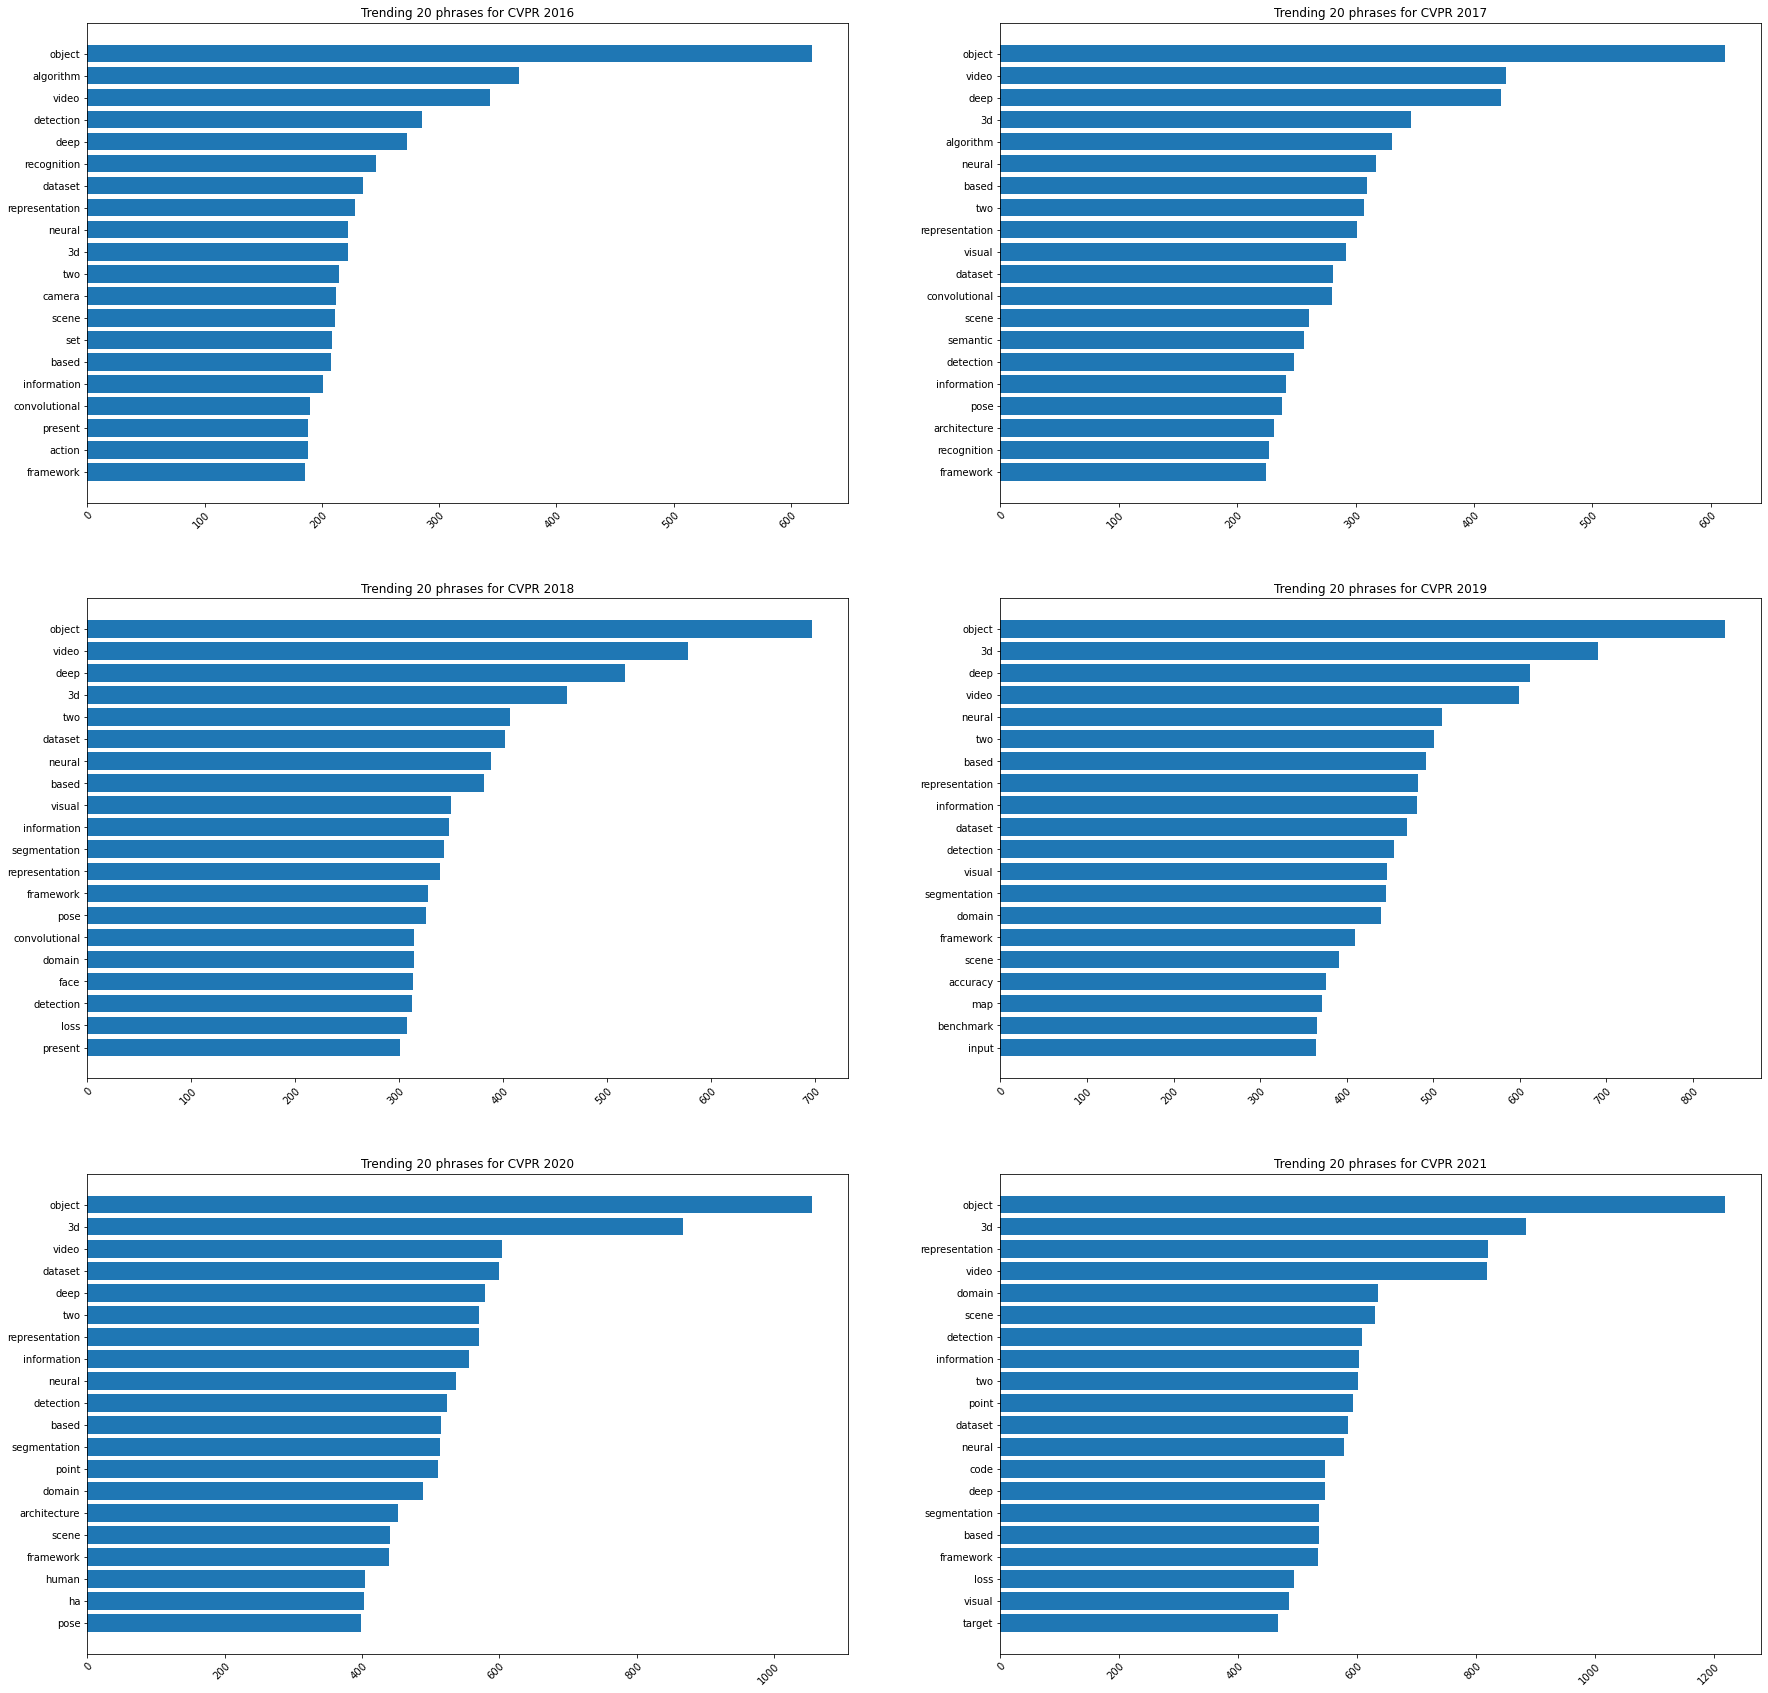

In [9]:
def get_trend_n_year(year, n):
    freq = tf.toarray()[np.where(np.array(data.YEAR)==year)[0], :].sum(0)
    word_inds = np.flip(np.argsort(freq))[:n]
    return tf_vectorizer.get_feature_names_out()[word_inds], freq[word_inds]

top_n = 20
fig, axes = plt.subplots(3, 2, figsize=(30, 30))
for year, ax in zip(range(2016, 2022), axes.reshape(-1)):
    names, counts = get_trend_n_year(year, top_n)
    ax.barh(y=np.flip(names), width=np.flip(counts))
    ax.set_title(f"Trending {top_n} phrases for CVPR {year}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

plt.show()

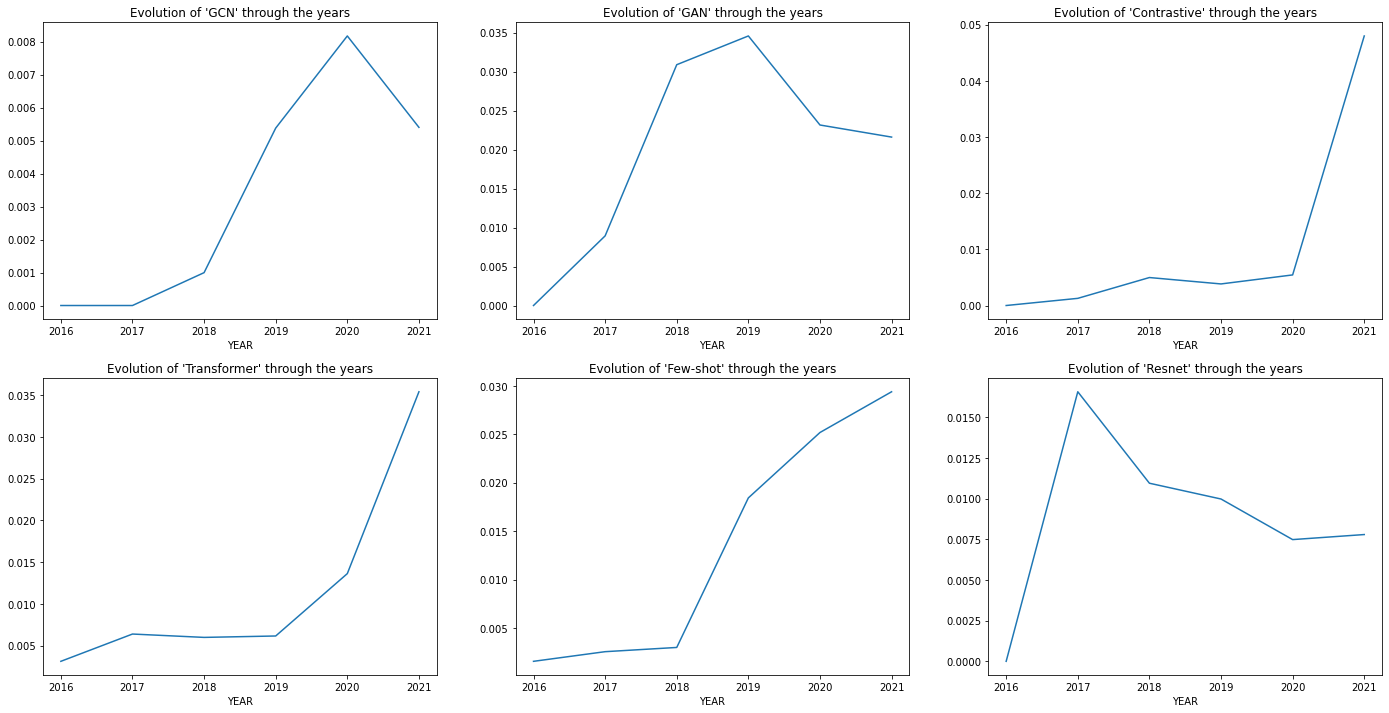

In [10]:
def trace_word_popularity(word):
    assert isinstance(word, str)
    word = word.strip().lower().translate(table)
    assert isinstance(diversity_papers, pd.DataFrame)
    is_word_in_list = np.array([feat==word for feat in tf_vectorizer.get_feature_names_out()])
    if not is_word_in_list.any():
        raise Exception("Couldn't find the word you were looking for.")
        
    if len(word.split()) > 1:
        raise Exception("Must be a 1 word long token separated by spaces.")
    
    total = diversity_papers.groupby('YEAR').count()

    word_idx = np.argwhere(is_word_in_list).item()
    count_df = (diversity_papers.groupby('YEAR').sum().n_themes
                .apply(lambda row: np.array(row))
                .apply(lambda row: row[row == word_idx].size).div(total.n_themes))
    return count_df

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
test_words = ["GCN", "GAN", "Contrastive", "Transformer", "Few-shot", "Resnet"]
for w, ax in zip(test_words, axes.reshape(-1)):
    counts = trace_word_popularity(w)
    counts.plot(ax=ax)
    ax.set_xticks(range(2016, 2022))
    ax.set_title(f"Evolution of '{w}' through the years")

In [11]:
#number of topics
n_topics=8

from sklearn.decomposition import LatentDirichletAllocation
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=321, verbose=0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [12]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [13]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if isinstance(temp_vector_sum, int):
            print(topic)
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

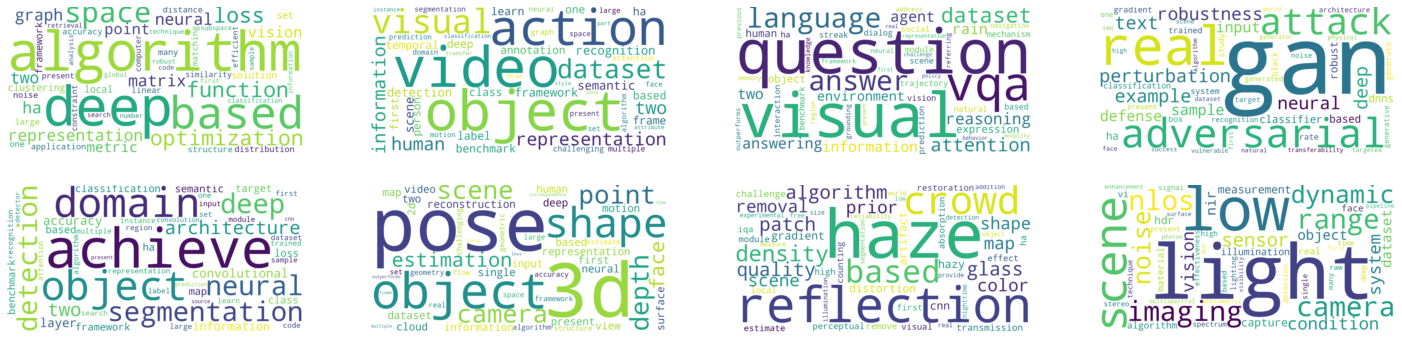

In [14]:
# Printing words from each topic
top_n_words = get_top_n_words(50, lda_keys, tf, tf_vectorizer)

fig, axes = plt.subplots(2, 4, figsize=(25, 6))
for tw, ax in zip(top_n_words, axes.reshape(-1)):
    wc = WordCloud(background_color="white", width=1600, height=800)
    wc.generate(tw)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
plt.show()

In [15]:
from sklearn.manifold import TSNE
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6869 samples in 0.004s...
[t-SNE] Computed neighbors for 6869 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6869
[t-SNE] Computed conditional probabilities for sample 2000 / 6869
[t-SNE] Computed conditional probabilities for sample 3000 / 6869
[t-SNE] Computed conditional probabilities for sample 4000 / 6869
[t-SNE] Computed conditional probabilities for sample 5000 / 6869
[t-SNE] Computed conditional probabilities for sample 6000 / 6869
[t-SNE] Computed conditional probabilities for sample 6869 / 6869
[t-SNE] Mean sigma: 0.011380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.892059
[t-SNE] KL divergence after 2000 iterations: 0.969708


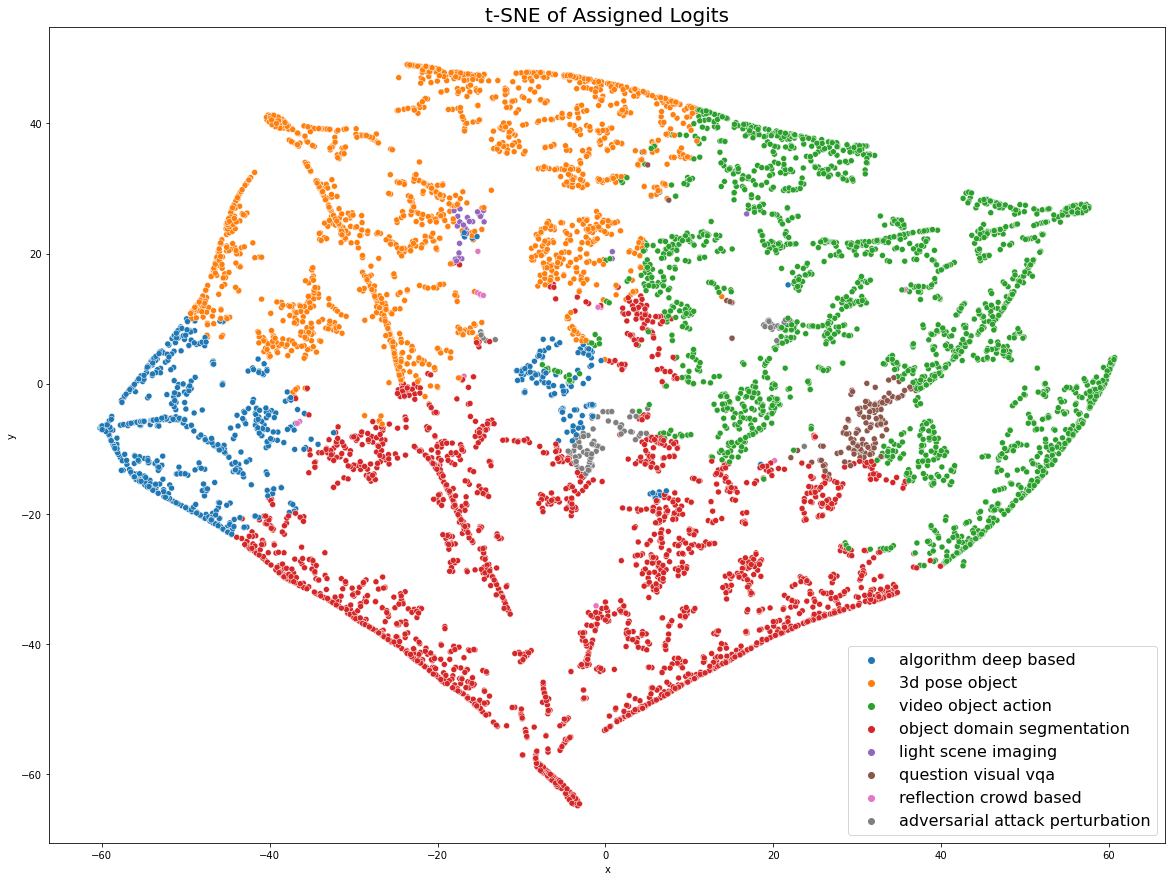

In [16]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

hue = []
for k in lda_keys:
    hue.append(top_3_words_lda[k])

disp_data = pd.DataFrame({'x': pd.Series(tsne_lda_vectors[:,0]), 'y': pd.Series(tsne_lda_vectors[:,1]), 'topic': pd.Series(hue)})
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(data=disp_data, x='x', y='y', hue='topic', ax=ax)
ax.set_title("t-SNE of Assigned Logits", fontsize=20)
ax.legend(loc="lower right", prop={'size':16})
plt.show()

In [17]:
for n in range(5):
    topic_most_pr = lda_topic_matrix[n].argsort()[-2:]
    print("Paper #{}: {}\n - top 2 topic: ({})+({})\n".format(n,title[n], top_3_words_lda[topic_most_pr[0]], top_3_words_lda[topic_most_pr[1]]))

Paper #0: Estimating Sparse Signals with Smooth Support via Convex Programming and Block Sparsity
 - top 2 topic: (object domain segmentation)+(algorithm deep based)

Paper #1: Parametric Object Motion from Blur
 - top 2 topic: (object domain segmentation)+(3d pose object)

Paper #2: Unsupervised Learning of Discriminative Attributes and Visual Representations
 - top 2 topic: (object domain segmentation)+(video object action)

Paper #3: Symmetry reCAPTCHA
 - top 2 topic: (reflection crowd based)+(video object action)

Paper #4: Predicting Motivations of Actions by Leveraging Text
 - top 2 topic: (question visual vqa)+(video object action)



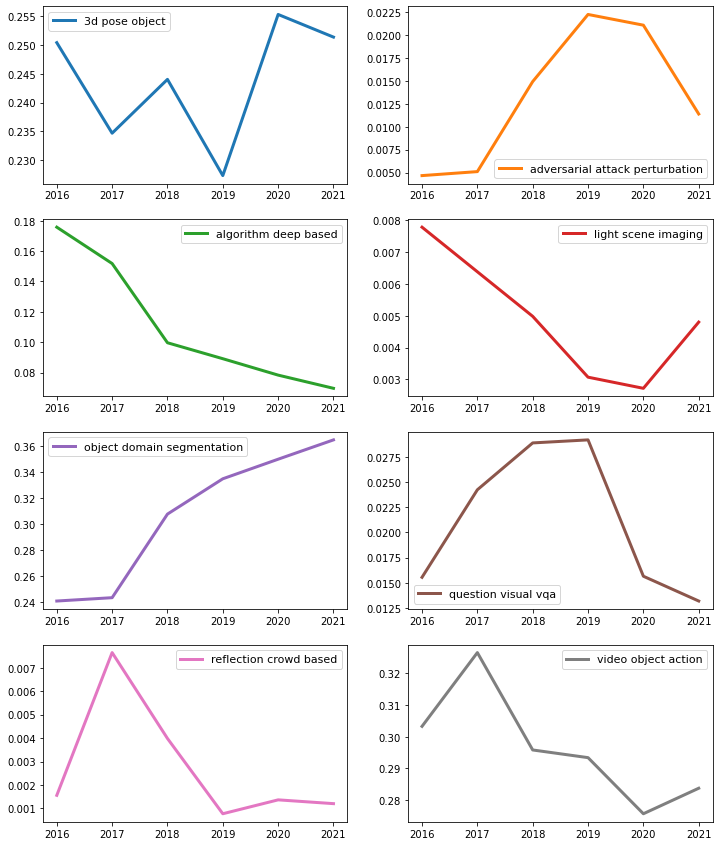

In [18]:
plt.rcParams['figure.figsize'] = (12,15)
lda_topics = [top_3_words_lda[k] for k in lda_keys]
# pd.crosstab(df_new['YEAR'], df_new['Dominant_Topic'], normalize='index').plot.bar(stacked=True)
axes = pd.crosstab(data['YEAR'].astype(int), pd.Series(lda_topics).astype('category'), normalize='index').plot(kind='line', subplots=True, sharex=False, linewidth=3, layout=(4, 2))
for ax in axes.reshape(-1):
    ax.set_xlabel("")
    ax.legend(prop={"size":11})
plt.show()

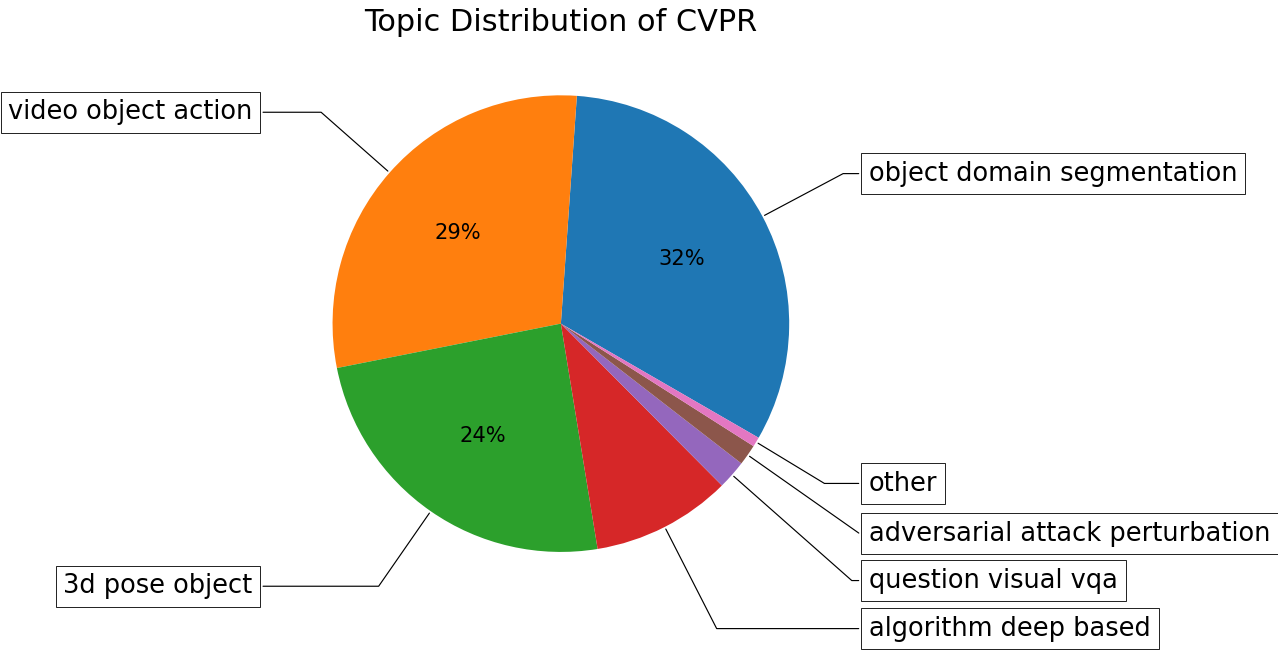

In [30]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=round(pct))
        else:
            return ''
    return my_autopct

inds = np.flip(np.argsort(lda_counts))

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi=84)

labels = np.array(top_3_words_lda)[lda_categories][inds]
labels = labels[:-1]
labels[-1] = "other"

values = np.array(lda_counts)[inds]
last = values[-2] + values[-1]
values = values[:-1]
values[-1] = last

wedges, texts, _ = ax.pie(values, wedgeprops=dict(width=1.0), startangle=-30, autopct=make_autopct(values), textprops={'fontsize': 18})

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    if i > 6:
        break
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0.3, 0.2, -0.05, -0.32][i-3] if i > 2 else 0.0
    ax.annotate(labels[i], xy=(x, y), xytext=((1.35)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=22, **kw)

ax.set_title("Topic Distribution of CVPR", fontsize=26)

plt.show()

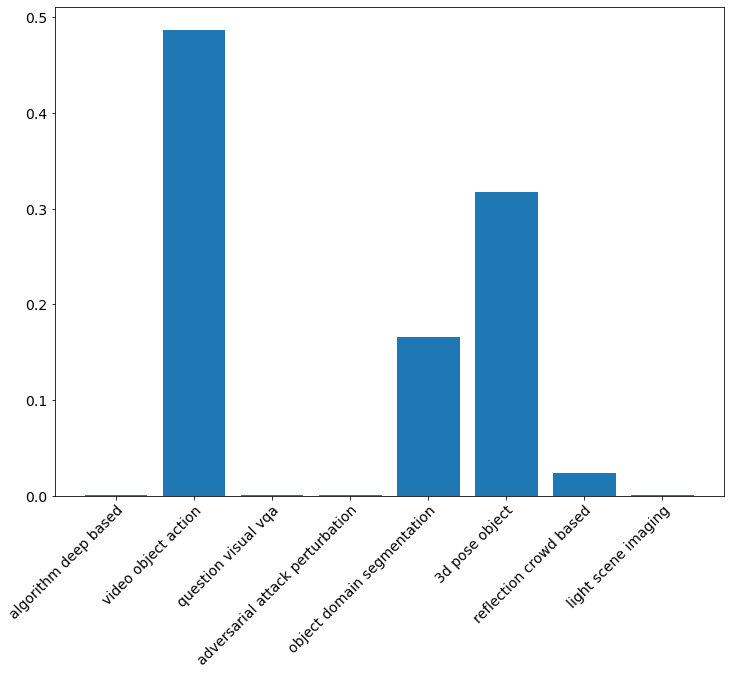

Coherent Parametric Contours for Interactive Video Object Segmentation
Interactive video segmentation systems aim at producing sub-pixel-level object boundaries for visual effect applications. Recent approaches mainly focus on using sparse user input (i.e. scribbles) for efficient segmentation, however, the quality of the final object boundaries is not satisfactory for the following reasons: (1) the boundary on each frame is often not accurate, (2) boundaries across adjacent frames wiggle around inconsistently, causing temporal flickering, and (3) there is a lack of direct user control for fine tuning. We propose Coherent Parametric Contours, a novel video segmentation propagation framework that addresses all the above issues. Our approach directly models the object boundary using a set of parametric curves, providing direct user controls for manual adjustment. A spatiotemporal optimization algorithm is employed to produce object boundaries that are spatially accurate and temporally st

In [20]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(x=top_3_words_lda, height=lda_topic_matrix[6])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()
print(title[6])
print(abstract[6])

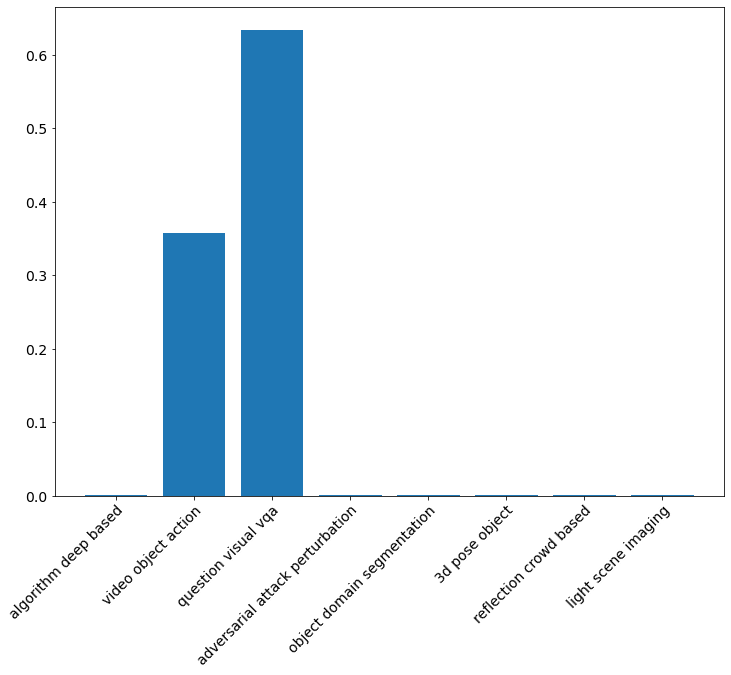

Visual7W: Grounded Question Answering in Images


In [21]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(x=top_3_words_lda, height=lda_topic_matrix[26])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.show()
print(title[26])

In [22]:
title_proc = []
for i in range(len(title)):
    t = title[i].strip().lower().translate(table).split()
    title_proc.append([lemm.lemmatize(w) for w in t])

# Calling the overwritten count vectorizer
def dummy(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words=sw, decode_error='ignore', tokenizer=dummy, preprocessor=dummy)
tv = tfidf_vectorizer.fit_transform(title_proc)
tv_norm = normalize(tv, axis=1)

In [23]:
from scipy.spatial.distance import jensenshannon as js
def find_n_related(inp_t, inp_ab, n, alpha=0.5):
    assert isinstance(inp_t, str)
    assert isinstance(inp_ab, str)
    # preprocess
    t_proc = inp_t.strip().lower().translate(table).split()
    ab_proc = inp_ab.strip().lower().translate(table).split()
    t_proc = [lemm.lemmatize(w) for w in t_proc]
    ab_proc = [lemm.lemmatize(w) for w in ab_proc]

    t_vec = tfidf_vectorizer.transform([t_proc]).toarray()
    t_vec = normalize(t_vec, axis=1)
    # print(t_vec.shape)
    t_scores = np.matmul(tv_norm.toarray(), t_vec.T).squeeze()

    ab_vec = tf_vectorizer.transform([ab_proc]).toarray()
    logits = lda.transform(ab_vec)
    # ab_scores = np.matmul(lda_topic_matrix, logits.T).squeeze()
    ab_scores = 1 - np.array([js(v.squeeze(), logits.squeeze(), 2) for v in lda_topic_matrix])

    scores = alpha * t_scores + (1-alpha) * ab_scores
    inds = np.flip(np.argsort(scores))[:n]
    retrieved = data.loc[inds, :]
    retrieved["Score"] = scores[inds]

    return retrieved

In [24]:
# Temporal Localization of Moments in Video Collections with Natural Language (ICCV2019)
# https://arxiv.org/abs/1907.12763
test_t = "Temporal Localization of Moments in Video Collections with Natural Language"
test_abs = """In this paper, we introduce the task of retrieving relevant video moments from a large corpus of untrimmed, unsegmented videos given a natural language query.
Our task poses unique challenges as a system must efficiently identify both the relevant videos and localize the relevant moments in the videos.
This task is in contrast to prior work that localizes relevant moments in a single video or searches a large collection of already-segmented videos.
For our task, we introduce Clip Alignment with Language (CAL), a model that aligns features for a natural language query to a sequence of short video clips that compose a candidate moment in a video.
Our approach goes beyond prior work that aggregates video features over a candidate moment by allowing for finer clip alignment.
Moreover, our approach is amenable to efficient indexing of the resulting clip-level representations, which makes it suitable for moment localization in large video collections.
We evaluate our approach on three recently proposed datasets for temporal localization of moments in video with natural language extended to our video corpus moment retrieval setting: DiDeMo, Charades-STA, and ActivityNet-captions.
We show that our CAL model outperforms the recently proposed Moment Context Network (MCN) on all criteria across all datasets on our proposed task, obtaining an 8%-85% and 11%-47% boost for average recall and median rank, respectively,
and achieves 5x faster retrieval and 8x smaller index size with a 500K video corpus."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR}): {s.Score:.3f}")

MAN: Moment Alignment Network for Natural Language Moment Retrieval via Iterative Graph Adjustment (CVPR2019): 0.644
Structured Multi-Level Interaction Network for Video Moment Localization via Language Query (CVPR2021): 0.603
Person Search with Natural Language Description (CVPR2017): 0.578
Tracking by Natural Language Specification (CVPR2017): 0.573
Read and Attend: Temporal Localisation in Sign Language Videos (CVPR2021): 0.567
Temporal Action Detection Using a Statistical Language Model (CVPR2016): 0.556
Natural Language Object Retrieval (CVPR2016): 0.553
Benchmarking Representation Learning for Natural World Image Collections (CVPR2021): 0.548
Spoken Moments: Learning Joint Audio-Visual Representations from Video Descriptions (CVPR2021): 0.527
Multi-stage Aggregated Transformer Network for Temporal Language Localization in Videos (CVPR2021): 0.524


In [25]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16955 (AAAI2021)
test_t = "Adversarial Defence by Diversified Simultaneous Training of Deep Ensembles"
test_abs = """Learning-based classifiers are susceptible to adversarial examples. Existing defence methods are mostly devised on individual classifiers.
Recent studies showed that it is viable to increase adversarial robustness by promoting diversity over an ensemble of models.
In this paper, we propose adversarial defence by encouraging ensemble diversity on learning high-level feature representations and gradient dispersion in simultaneous training of deep ensemble networks.
We perform extensive evaluations under white-box and black-box attacks including transferred examples and adaptive attacks.
Our approach achieves a significant gain of up to 52% in adversarial robustness, compared with the baseline and the state-of-the-art method on image benchmarks with complex data scenes.
The proposed approach complements the defence paradigm of adversarial training, and can further boost the performance. The source code is available at https://github.com/ALIS-Lab/AAAI2021-PDD."""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR}): {s.Score:.3f}")

Class-Aware Robust Adversarial Training for Object Detection (CVPR2021): 0.575
Efficient Adversarial Training With Transferable Adversarial Examples (CVPR2020): 0.530
Adversarial Robustness under Long-Tailed Distribution (CVPR2021): 0.521
On the Robustness of Semantic Segmentation Models to Adversarial Attacks (CVPR2018): 0.521
Ensemble Generative Cleaning With Feedback Loops for Defending Adversarial Attacks (CVPR2020): 0.516
Single-Step Adversarial Training With Dropout Scheduling (CVPR2020): 0.513
A Self-supervised Approach for Adversarial Robustness (CVPR2020): 0.485
Handwriting Recognition in Low-Resource Scripts Using Adversarial Learning (CVPR2019): 0.485
Generative Adversarial Perturbations (CVPR2018): 0.474
Stacked Generative Adversarial Networks (CVPR2017): 0.474


In [26]:
# https://ojs.aaai.org/index.php/AAAI/article/view/16815 (AAAI2021)
test_t = "Learning Invariant Representations using Inverse Contrastive Loss"
test_abs = """Learning invariant representations is a critical first step in a number of machine learning tasks.
A common approach is given by the so-called information bottleneck principle in which an application dependent function of mutual information is carefully chosen and optimized.
Unfortunately, in practice, these functions are not suitable for optimization purposes since these losses are agnostic of the metric structure of the parameters of the model.
In our paper, we introduce a class of losses for learning representations that are invariant to some extraneous variable of interest by inverting the class of contrastive losses, i.e., inverse contrastive loss (ICL).
We show that if the extraneous variable is binary, then optimizing ICL is equivalent to optimizing a regularized MMD divergence.
More generally, we also show that if we are provided a metric on the sample space, our formulation of ICL can be decomposed into a sum of convex functions of the given distance metric.
Our experimental results indicate that models obtained by optimizing ICL achieve significantly better invariance to the extraneous variable for a fixed desired level of accuracy.
In a variety of experimental settings, we show applicability of ICL for learning invariant representations for both continuous and discrete protected/extraneous variables.
The project page with code is available at https://github.com/adityakumarakash/ICL"""
for _, s in find_n_related(test_t, test_abs, 10).iterrows():
    print(f"{s.TITLE} (CVPR{s.YEAR}): {s.Score:.3f}")

Learning an Invariant Hilbert Space for Domain Adaptation (CVPR2017): 0.554
The Multiverse Loss for Robust Transfer Learning (CVPR2016): 0.541
A Graph Regularized Deep Neural Network for Unsupervised Image Representation Learning (CVPR2017): 0.532
Understanding the Behaviour of Contrastive Loss (CVPR2021): 0.526
Adversarial Invariant Learning (CVPR2021): 0.515
Exploring Complementary Strengths of Invariant and Equivariant Representations for Few-Shot Learning (CVPR2021): 0.512
Wasserstein Contrastive Representation Distillation (CVPR2021): 0.512
A Sufficient Condition for Convergences of Adam and RMSProp (CVPR2019): 0.490
Circle Loss: A Unified Perspective of Pair Similarity Optimization (CVPR2020): 0.490
Unsupervised Embedding Learning via Invariant and Spreading Instance Feature (CVPR2019): 0.490


In [27]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


Text(0.5, 1.0, 'Prof. N. Vasconcelos interested in')

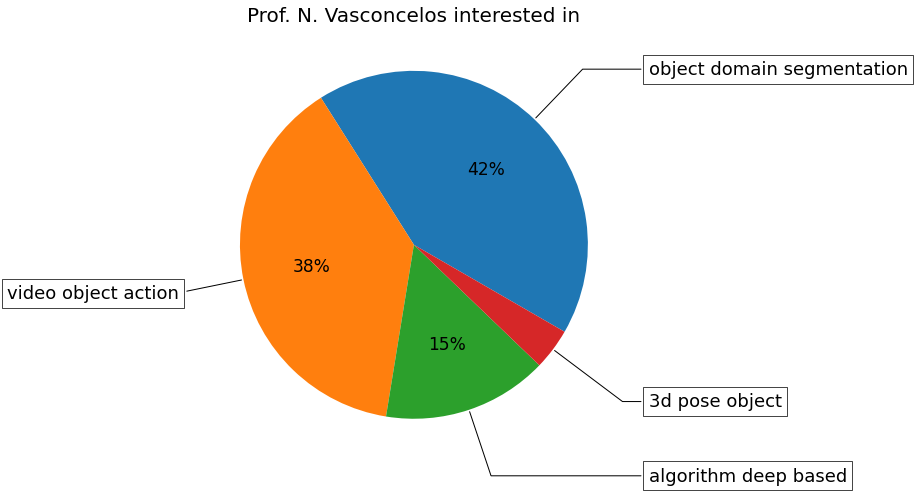

In [28]:
def make_autopct(values):
    def my_autopct(pct):
        if pct > 10:
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.0f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

test_auth = 'N. Vasconcelos'
authors = list(data.Authors.values)
authors = [[a_.strip() for a_ in a.split(";")] for a in authors]
out_topics = []
for i, a in enumerate(authors):
    if test_auth in a:
        out_topics.append(top_3_words_lda[lda_keys[i]])
topic_counts = pd.Series(out_topics).value_counts()
fig, ax = plt.subplots(figsize=(8, 8))
# ax.pie(topic_counts.values, labels=topic_counts.index, textprops={'fontsize': 16}, autopct='%1.f%%', colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# ax.set_ylabel("")
# ax.set_title(f"Prof. {test_auth} interested in", fontsize=20)

wedges, texts, _ = ax.pie(topic_counts.values, wedgeprops=dict(width=1.0), startangle=-30, autopct=make_autopct(values), textprops={'fontsize': 17}, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    if i > 6:
        break
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0.3, 0.2, -0.05, -0.32][i-3] if i > 2 else 0.0
    ax.annotate(topic_counts.index[i], xy=(x, y), xytext=((1.35)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title(f"Prof. {test_auth} interested in", fontsize=20)

Text(0.5, 1.0, 'Stanford Univ. interested in')

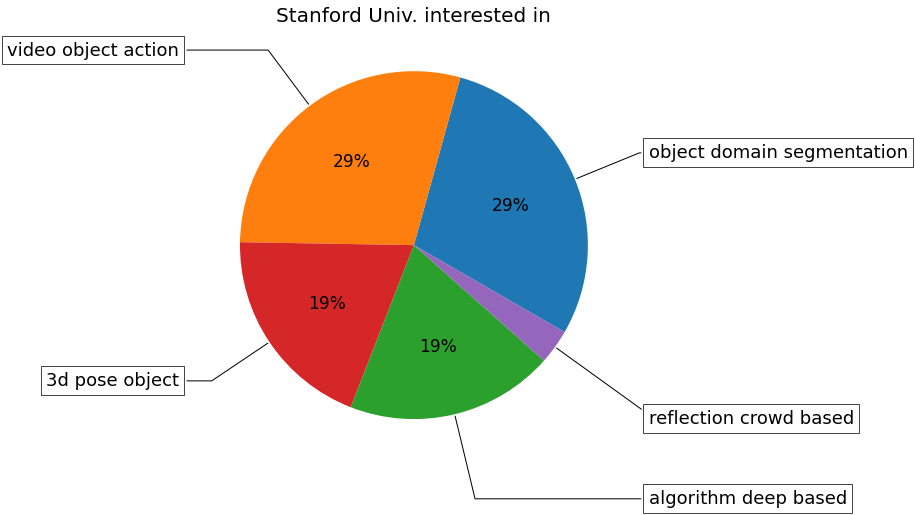

In [29]:
test_aff = 'Stanford Univ., Stanford, CA, USA'
affs = list(data.Affiliations.values)
affs = [[a_.strip() for a_ in a.split("'")] for a in affs if isinstance(a, str)]
out_topics = []
for i, a in enumerate(affs):
    if test_aff in a:
        out_topics.append(top_3_words_lda[lda_keys[i]])
topic_counts = pd.Series(out_topics).value_counts()
fig, ax = plt.subplots(figsize=(8, 8))
# ax.pie(topic_counts.values, labels=topic_counts.index, textprops={'fontsize': 16}, autopct='%1.f%%', colors=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd'])
# ax.set_ylabel("")

wedges, texts, _ = ax.pie(topic_counts.values, wedgeprops=dict(width=1.0), startangle=-30, autopct=make_autopct(values), textprops={'fontsize': 17}, colors=['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    if i > 6:
        break
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    offset = [0.1, 0.3, 0.2, -0.05, -0.32][i-3] if i > 2 else 0.0
    ax.annotate(topic_counts.index[i], xy=(x, y), xytext=((1.35)*np.sign(x), (1.4+offset)*y),
                horizontalalignment=horizontalalignment, fontsize=18, **kw)

ax.set_title(f"{test_aff.split(',')[0]} interested in", fontsize=20)

In [96]:
pd.Series(out_topics).value_counts().values

array([9, 9, 6, 6, 1])

In [30]:
import pickle
with open("./saved_models/lda_cvpr.pickle", 'wb') as f:
    pickle.dump(lda, f)

In [31]:
np.save("./saved_models/matrix_cvpr.npy", lda_topic_matrix)